In [1]:
import pandas as pd
from datetime import datetime, timedelta
import plotly.graph_objects as go
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/javier/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
df = pd.read_csv('2020 - Semana 1 (05012020).txt',error_bad_lines=False,encoding = 'unicode_escape', 
                 header=3, sep='\t', skiprows=[4], skipinitialspace=True, 
                 usecols=['Título','Título/Descripción', 'Cadena', 'Fecha', 'Género','Público objetivo', 
                          'Productora','Calificación de Edad','Ind. 4+ (inv)','Amas de Casa (c/inv.)'
                          ,'Ind. 4 - 12 (c/inv.)', 'Ind. 16+ (c/inv.)','Ind. 4+ (inv).1','Amas de Casa (c/inv.).1',
                          'Ind. 4 - 12 (c/inv.).1', 'Ind. 16+ (c/inv.).1'])

#ELIMINAMOS LAS CABECERAS DE LOS PROGRAMAS EN LA COLUMNA TÍTULO
df.dropna(inplace = True)
df = df[df.Título.str.startswith('<<')]
df.reset_index(drop = True,inplace = True)

#ELIMINAMOS LOS SIMBOLOS <> DEL DATA FRAME
df1 = pd.DataFrame()
for i in df.columns:
    df1 = pd.concat([df1,df.loc[:,str(i)].str.translate({ord(x): None for x in ('><')})], axis = 1)
    
#DIVIDIMOS LA COLUMNA EN DOS PARA PODER OPERAR SOLO CON LA HORA 
#(NO SE PUEDE PASAR A DATETIME YA QUE NO ESTÁ EN EL RANGO ADECUADO)
df1[['Hora','Minuto']] = df1.Título.str.split(':', expand = True)
#df1.head(5)

#PASAMOS LA COLUMNA FECHA A DATETIME PARA PODER RESTAR DIAS CUANDO SEA NECESARIO
df1['Fecha'] = pd.to_datetime(df1['Fecha'],format = "%d/%m/%Y", dayfirst=True)
#df1.dtypes

#SE CAMBIA EL TIPO DE DATO EN LAS COLUMNAS HORA MINUTO PARA PODER TRANSFORMAR A RANGO 00:00-23:00(STR-INT)
df1 = df1.astype({'Hora':'int','Minuto':'int'})
#df1.dtypes

#SUMAMOS 1 DÍA A LAS HORAS SUPERIORES A 23
ind = df1[df1['Hora']>23].index
df1.loc[ind,'Fecha']= df1.loc[ind,'Fecha'] + timedelta(days=1)

#CONVERTIMOS PARA TENER RANGO 00-23
df1.Hora = df1.Hora.replace({24:0,25:1,26:2})

#SE SUSTITUYE EL 24 POR 0 PARA TENER RANGO 00-23
#df1.Hora = df1.Hora.replace(24,0)


#CONVIERTO LA FECHA A STRING PARA PODER UNIRLO CON LA HORA
df1['Fecha']=df1.Fecha.apply(lambda x:str(x.date()))
df1[df1['Cadena']=='La1'].head(1413)

#VOLVEMOS A CONVERTIR HORA Y MINUTO A STR PARA PODER UNIRLOS CON ':' COMO SEPARADOR
df1 = df1.astype({'Hora':'str', 'Minuto':'str'})

#UNIMOS HORA Y MINUTO PARA DESPUÉS UNIRLO A LA FECHA Y CONVERTIRLO EN TIMESTAMP
df1 ['Tiempo'] = df1[['Hora', 'Minuto']].apply(lambda x: ':'.join(x), axis=1)
df1 ['Fecha_comp'] = df1[['Fecha', 'Tiempo']].apply(lambda x: ' '.join(x), axis=1)
df1.Fecha_comp = pd.to_datetime(df1.Fecha_comp)

#ELIMINAMOS LAS COLUMNAS GENERADAS Y USADAS PARA LAS TRANSFORMACIONES
df1 = df1.drop(['Tiempo','Hora', 'Minuto','Fecha','Título'], axis = 1)
#,'Descripción'

#CAMBIO COMA POR PUNTO PARA PODER CONVERTIR A ARRAY DE FLOAT
column = ['Ind. 4+ (inv)','Amas de Casa (c/inv.)', 'Ind. 4 - 12 (c/inv.)','Ind. 16+ (c/inv.)',
          'Ind. 4+ (inv).1','Amas de Casa (c/inv.).1','Ind. 4 - 12 (c/inv.).1', 'Ind. 16+ (c/inv.).1']
for i in column:
    df1[i]=df1[i].str.replace(',','.')
    
#CREO LA VARIABLE TARGET CON LAS COLUMNAS NECESARIAS
df1['Target']= df1[column].apply(lambda x:'/'.join(x),axis=1)
#df1['Target']= df1.Target.str.split('/').apply(lambda x : [float(i) for i in x])
df1['Target']= df1.Target.str.split('/').apply(lambda x:np.array(x,dtype=np.float32))

#ELIMINAMOS LAS VARIABLES UTILIZADAS EN TARGET
df1 = df1.drop(column,axis = 1)

#ELIMINAMOS TITULO/DESCRIPCION DE MOMENTO (!)
#df1 = df1.drop('Título/Descripción',axis = 1)

#ORDENO LAS COLUMNAS DE MI DATA FRAME (!) 
df1 = df1[['Fecha_comp','Título/Descripción','Cadena', 'Género', 'Público objetivo', 'Productora',
       'Calificación de Edad', 'Target']]

#ELIMINO CADENAS REGIONALES, YA QUE BUSCO ESTIMACIONES A NIVEL NACIONAL
regionales = ['C.SUR', 'TV3', 'ETB1', 'ETB2', 'TVG',
     'TELEMADRID', 'CSUR-AND', 'TVCAN', 'ETB4', 'CMM', '8TV',
      'ETB3', 'LAOTRA', 'TPA2', 'ARAGON TV', 'TPA', 'IB3',
      'LA 7TV', 'TVG2', 'La 7', 'SUPER3/33', 'TV MEDITERRANEO', 'AND-TV',
      'A PUNT', '8MADRID','3/24','BOM Cine']
df1 = df1[~df1['Cadena'].isin(regionales)]

In [23]:
df1.Cadena.unique()

array(['La1', 'La2', 'T5', 'A3', 'CUATRO', 'LA SEXTA', '24H', 'NEOX',
       'NOVA', 'AXN', 'BARÇA TV', 'BLAZE', 'HISTORIA', 'MOVISTAR ACCION',
       'MOVISTAR COMEDIA', 'MOVISTAR DRAMA', 'MOVISTAR DEPORTES',
       'CALLE 13', 'CANAL COCINA', 'CANAL HOLLYWOOD', 'CAZA Y PESCA',
       'SUNDANCE TV', 'CLAN', 'COSMOPOLITAN', 'DARK',
       'MOVISTAR CINE ESPAÑOL', 'DECASA', 'DISCOVERY', 'DISNEY CH +1',
       'DISNEY CHANNEL', 'EUROSPORT', 'XTRM', 'FDF', 'FOX',
       'MOVISTAR GOLF', 'MTV ESP', 'NATIONAL GEOGRAPHIC', 'NICKELODEON',
       'ODISEA', 'PANDA', 'COMEDY CENTRAL', 'DISNEY JUNIOR', 'SYFY',
       'SOL MÚSICA', 'SOMOS', 'TCM', 'TELEDEPORTE', 'TNT', 'VIAJAR',
       'DISNEY XD', 'BOING', 'MOVISTAR CINEDOC&ROLL',
       'CANAL HOLLYWOOD +1', 'TRECE', 'ESPORT3', 'NICK JR',
       'CRIMEN + INVESTIGACION', 'NGC WILD', 'DIVINITY', 'ENERGY', 'DMAX',
       'PARAMOUNT NETWORK', 'AXN WHITE', 'MOVISTAR SERIES', 'TCM +1',
       'FOX LIFE', 'AMC', 'MEGA', 'MOVISTAR F1', 'MOVISTAR ESTREN

In [25]:
dfz.head()

,2522,2620,2625,2628,4250,4252,4253,4257,4260,4263,...,74732,74733,74734,74735,74736,74737,74738,74739,74740,74741
level_0,2522,2620,2625,2628,4250,4252,4253,4257,4260,4263,...,74732,74733,74734,74735,74736,74737,74738,74739,74740,74741
index,2522,2620,2625,2628,4250,4252,4253,4257,4260,4263,...,118219,118220,118221,118222,118223,118224,118225,118226,118227,118228
Fecha_comp,2020-01-01T13:18:00.000000000,2020-01-01T14:40:00.000000000,2020-01-01T14:41:00.000000000,2020-01-01T14:41:00.000000000,2020-01-01T08:15:00.000000000,2020-01-01T08:15:00.000000000,2020-01-01T08:15:00.000000000,2020-01-01T08:16:00.000000000,2020-01-01T08:17:00.000000000,2020-01-01T08:18:00.000000000,...,2020-01-01T10:07:00.000000000,2020-01-01T10:08:00.000000000,2020-01-01T10:09:00.000000000,2020-01-01T10:10:00.000000000,2020-01-01T10:11:00.000000000,2020-01-01T10:12:00.000000000,2020-01-01T10:13:00.000000000,2020-01-01T10:14:00.000000000,2020-01-01T10:15:00.000000000,2020-01-01T10:16:00.000000000
Título/Descripción,AVANCE PROGRAMACION / SENDEROS DEL MUNDO-GUARD...,PUBLICIDAD / NO SOLAPADA,AVANCE PROGRAMACION / EL ABUELO,AVANCE PROGRAMACION / UN PAIS PARA ESCUCHARLO,"AVANCE PROGRAMACION / DIOS MIO,¿PERO QUE TE HE...",AUTOPROMOCION / CON LA COLABORACION DE MEDIASE...,AUTOPROMOCION / MEDIASET ESPAÑA,AUTOPROMOCION / FUTBOL:EUROCOPA,AUTOPROMOCION / DISFRUTA EN MEDIASET ESPAÑA,AUTOPROMOCION / MEDIASET ESPAÑA,...,SOL TECHNO,SOL TECHNO,SOL TECHNO,SOL TECHNO,SOL TECHNO,SOL TECHNO,SOL TECHNO,SOL TECHNO,SOL TECHNO,SOL TECHNO
Cadena,La2,La2,La2,La2,T5,T5,T5,T5,T5,T5,...,SOL MÚSICA,SOL MÚSICA,SOL MÚSICA,SOL MÚSICA,SOL MÚSICA,SOL MÚSICA,SOL MÚSICA,SOL MÚSICA,SOL MÚSICA,SOL MÚSICA


In [29]:
col = dfz.index
ind = dfz.columns

In [67]:
dfz.loc['Cadena',:].value_counts().sort_values()

CUATRO                      2
La2                         4
24H                        13
T5                         30
A3                         35
LA SEXTA                   37
CANAL HOLLYWOOD            44
DISNEY CHANNEL             61
CLAN                      108
COMEDY CENTRAL            179
CALLE 13                  179
AXN                       271
NOVA                      304
HISTORIA                  305
DISCOVERY                 313
FOX                       320
NATIONAL GEOGRAPHIC       377
ODISEA                    430
MOVISTAR ACCION           458
SUNDANCE TV               473
COSMOPOLITAN              478
BLAZE                     491
MTV ESP                   517
SOL MÚSICA                527
MOVISTAR CINE ESPAÑOL     560
SYFY                      579
DISNEY JUNIOR             600
CANAL COCINA              623
MOVISTAR DRAMA            643
NICKELODEON               670
MOVISTAR COMEDIA          697
DECASA                    819
EUROSPORT                 884
PANDA     

In [22]:
dfz.loc['Cadena',:].unique()

array(['La2', 'T5', 'A3', 'CUATRO', 'LA SEXTA', '24H', 'NOVA', 'AXN',
       'BARÇA TV', 'BLAZE', 'HISTORIA', 'MOVISTAR ACCION',
       'MOVISTAR COMEDIA', 'MOVISTAR DRAMA', 'MOVISTAR DEPORTES',
       'CALLE 13', 'CANAL COCINA', 'CANAL HOLLYWOOD', 'CAZA Y PESCA',
       'SUNDANCE TV', 'CLAN', 'COSMOPOLITAN', 'DARK',
       'MOVISTAR CINE ESPAÑOL', 'DECASA', 'DISCOVERY', 'DISNEY CH +1',
       'DISNEY CHANNEL', 'EUROSPORT', 'XTRM', 'FOX', 'MOVISTAR GOLF',
       'MTV ESP', 'NATIONAL GEOGRAPHIC', 'NICKELODEON', 'ODISEA', 'PANDA',
       'COMEDY CENTRAL', 'DISNEY JUNIOR', 'SYFY', 'SOL MÚSICA'],
      dtype=object)

In [18]:
#REVISAMOS EL NUMERO DE TARGET A 0 POR CADENA
df1.reset_index(inplace = True)
counter = 0
dfz = pd.DataFrame()
for i,v in enumerate(df1.Target):
        if (v[4] == 0.0) & (df1.Fecha_comp[i].day == 1)  :
            counter+=1
            dfz = pd.concat([dfz,df1.loc[i,:]], axis=1)
            print(counter)
                             

KeyboardInterrupt: 

In [7]:
#REVISAMOS QUE HAYA CONTINUIDAD EN LA MARCA HORARIA
#RESETEAR INDICE
df2 = df1.sort_values('Fecha_comp')
df2.reset_index(drop = True,inplace = True)
counter = 0 
for i in df2.index:
    if i >= 1:
        if  (df2.Fecha_comp[i] - df2.Fecha_comp[i-1] > timedelta(minutes=1)):
            print(i)
            print(df1.iloc[i,:])
            counter+=1
    
    
print(counter)

0


In [3]:
df1.Target[0]

array([2.764000e+00, 3.066000e+00, 8.800000e-01, 2.992000e+00,
       1.245629e+03, 5.697780e+02, 3.776900e+01, 1.176382e+03],
      dtype=float32)

In [4]:
prdos = df1.groupby(['Fecha_comp','Cadena']).max()
ser = prdos.groupby('Fecha_comp').Target[4].sum()

KeyboardInterrupt: 

In [4]:
#PRUEBA DE DATAFRAME OBJETIVO PARA MODELO SARIMAX
#escogemos las columnas para copiar
df['Ind. 4+ (inv).1']=df['Ind. 4+ (inv).1'].str.replace(',','.')
df['Fecha_comp'] = df1.Fecha_comp
df = df.astype({'Ind. 4+ (inv).1':'float'})
df['cadena'] = df1.Cadena
pr = df[['Fecha_comp','cadena','Ind. 4+ (inv).1']]

#selecciono el valor máximo por cadena, para quitarme los duplicados,
prdos = pr.groupby(['Fecha_comp','cadena']).max()
ser = prdos.groupby('Fecha_comp')['Ind. 4+ (inv).1'].sum()
pr3 = ser.to_frame()

In [69]:
#PLOTEAR EL DATAFRAME OBJETIVO
#audiencia media de todo el dataset disponible
dmin = ser.index.min()
dmax = ser.index.max()
amin = 0
amax = ser.values.max()

fig = go.Figure(data=go.Scatter(x=ser.index, y= ser.values), 
                layout={'xaxis':{'range':[dmin, dmax]},
                        'yaxis':{'range':[amin, amax]}})
fig.show()

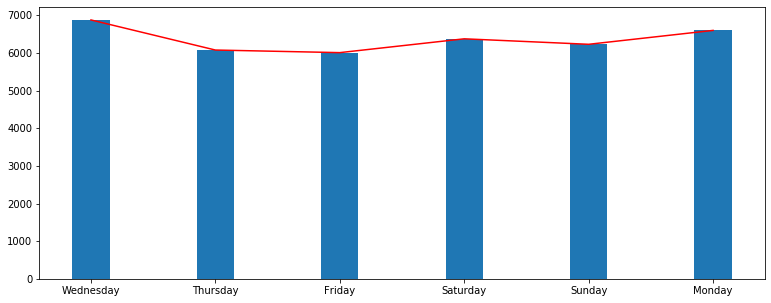

In [68]:
#PLOTEAMOS LA AUDIENCIA MEDIA POR DÍA DE LA SEMANA
df_sem = pr3.groupby(pd.Grouper(freq = 'D' )).mean()

f, ax = plt.subplots(figsize=(13,5))
plt.bar(df_sem.index, df_sem['Ind. 4+ (inv).1'].values, width= 0.3, tick_label = df_sem.index.day_name())
plt.plot(df_sem, color = 'red')

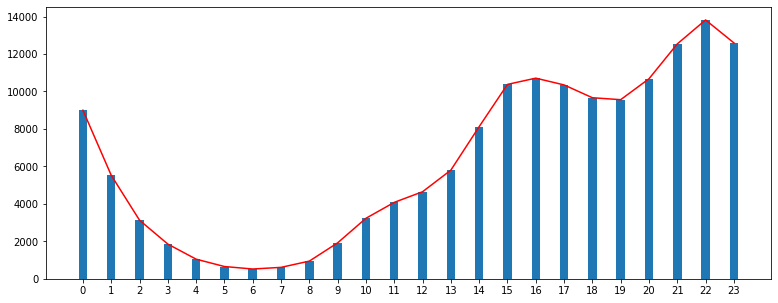

In [75]:
#PLOTEAMOS LA AUDIENCIA MEDIA POR HORA
df_hora = pr3.groupby(pr3.index.hour).mean()

f, ax = plt.subplots(figsize=(13,5))
plt.bar(df_hora.index, df_hora['Ind. 4+ (inv).1'].values, width= 0.3,tick_label = df_hora.index)
plt.plot(df_hora, color = 'red')

In [76]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

/home/javier/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency T will be used.



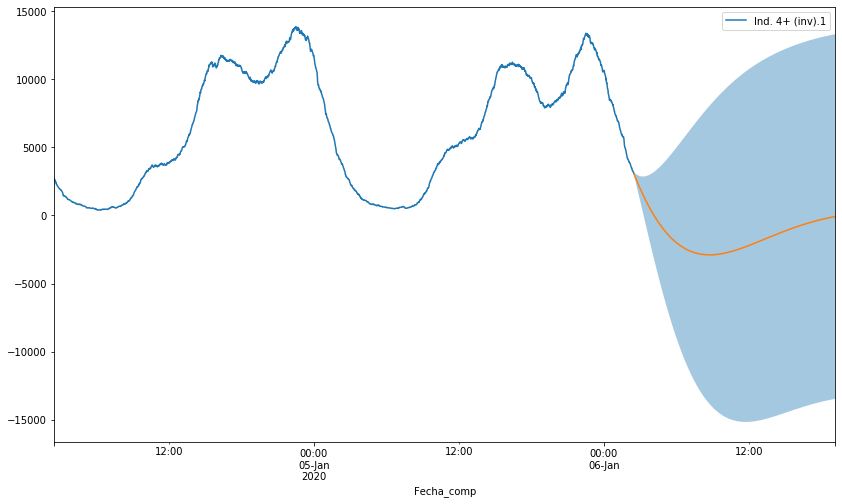

In [136]:
model = SARIMAX(pr3, order = (2, 0, 1),freq='T').fit()
prediction = model.get_forecast(steps = 1000)
lower = prediction.conf_int()["lower Ind. 4+ (inv).1"]
upper = prediction.conf_int()["upper Ind. 4+ (inv).1"]
fig, ax = plt.subplots()
pr3.truncate(before = "2020-01-04 02:30:00").plot(ax = ax,figsize = (14, 8))
prediction.predicted_mean.plot(ax = ax)
ax.fill_between(lower.index, lower, upper, alpha = 0.4)
plt.show()

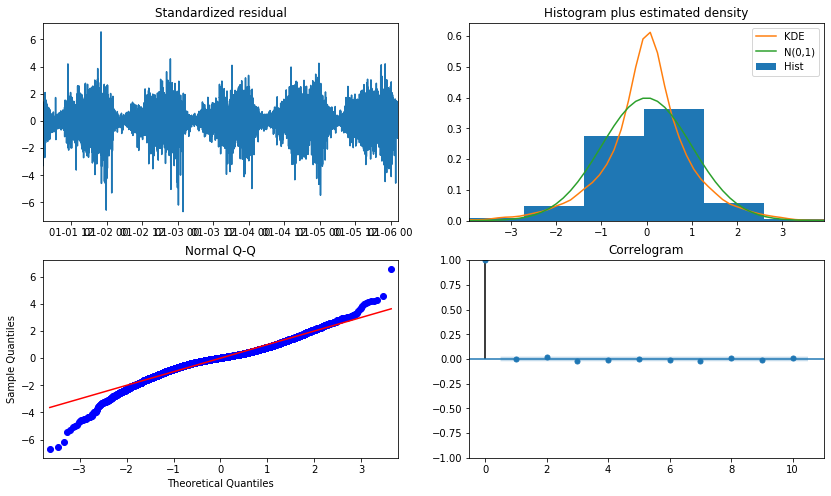

In [130]:
model.plot_diagnostics(figsize = (14, 8))
plt.show()

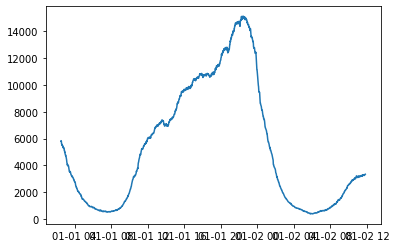

In [147]:
plt.plot(ser[0:2000])

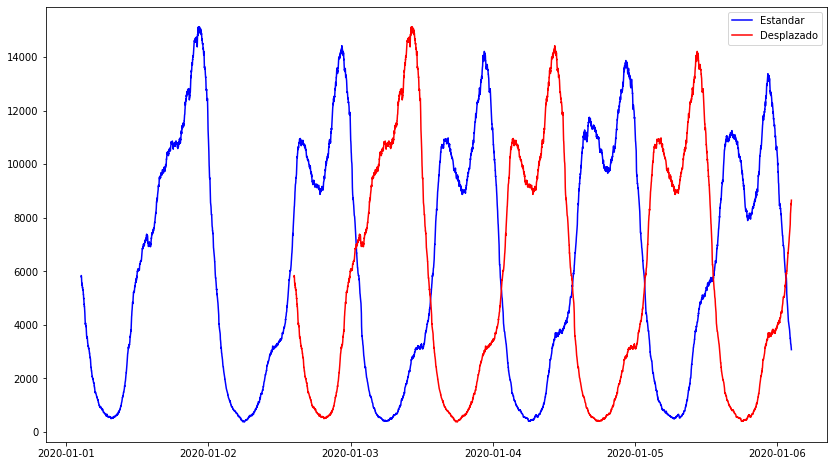

-0.8435757199967229


In [214]:
lags = 2158
plt.figure(figsize=(14,8))
plt.plot(pr3['Ind. 4+ (inv).1'],label='Estandar', color = 'blue')
plt.plot(ser[:].shift(lags), label='Desplazado', color = 'red')
plt.legend()

plt.show()
print(ser.corr(ser.shift(lags)))

/home/javier/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning:

invalid value encountered in sqrt



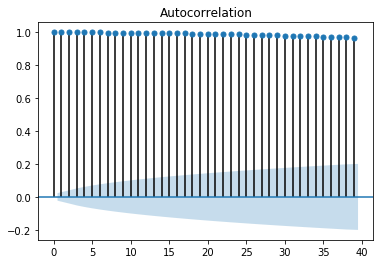

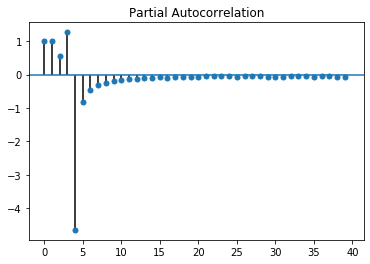

In [139]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(pr3)
plot_pacf(pr3)
plt.show()

In [28]:
from statsmodels.tsa.stattools import adfuller

In [29]:
adfuller(ser)

(-4.9198028904536235,
 3.190769111090481e-05,
 35,
 7164,
 {'1%': -3.43126312739421,
  '5%': -2.8619435304007217,
  '10%': -2.5669847951004168},
 73857.78619718425)

In [35]:
df1[(df1['Fecha_comp']== pd.to_datetime('2020-01-01 04:17:00')) & (df1['Cadena']== 'REAL MADRID HD')]

,Fecha_comp,Título/Descripción,Cadena,Género,Público objetivo,Productora,Calificación de Edad,Target
174475,2020-01-01 04:17:00,HOY JUGAMOS,REAL MADRID HD,DEPORTES,FAMILIAR,REAL MADRID MULTIMEDIA,Sin Preaviso,"[0.012, 0.0, 0.0, 0.013, 5.205, 0.0, 0.0, 5.205]"
174605,2020-01-01 04:17:00,CONECTA ENTREVISTA / HUGO SANCHEZ,REAL MADRID HD,INFORMACIÓN,FAMILIAR,REAL MADRID MULTIMEDIA,Todos los Públicos,"[0.012, 0.0, 0.0, 0.013, 5.205, 0.0, 0.0, 5.205]"


In [14]:
df1[df1['Cadena'] == 'BOING'].iloc[114:120,:]

,Fecha_comp,Título/Descripción,Cadena,Género,Público objetivo,Productora,Calificación de Edad,Target
109696,2020-01-01 02:26:00,MR.BEAN-DIBUJOS,BOING,FICCIÓN,FAMILIAR,MULTIPRODUCTORA,Todos los Públicos,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
109697,2020-01-01 02:27:00,MR.BEAN-DIBUJOS,BOING,FICCIÓN,FAMILIAR,MULTIPRODUCTORA,Todos los Públicos,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
109698,2020-01-01 02:28:00,MR.BEAN-DIBUJOS,BOING,FICCIÓN,FAMILIAR,MULTIPRODUCTORA,Todos los Públicos,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
109699,2020-01-01 02:29:00,MR.BEAN-DIBUJOS,BOING,FICCIÓN,FAMILIAR,MULTIPRODUCTORA,Todos los Públicos,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
109700,2020-01-01 02:30:00,MR.BEAN-DIBUJOS,BOING,FICCIÓN,FAMILIAR,MULTIPRODUCTORA,Todos los Públicos,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
109701,2020-01-01 02:31:00,MR.BEAN-DIBUJOS,BOING,FICCIÓN,FAMILIAR,MULTIPRODUCTORA,Todos los Públicos,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [21]:
df1[df1['Cadena'] == 'BOING'].iloc[1620:1654,:]

,Fecha_comp,Título/Descripción,Cadena,Género,Público objetivo,Productora,Calificación de Edad,Target
266584,2020-01-02 05:28:00,THE HAPPOS FAMILY,BOING,FICCIÓN,FAMILIAR,BOOMERANG,Todos los Públicos,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
266585,2020-01-02 05:30:00,EL SHOW DE TOM Y JERRY,BOING,FICCIÓN,FAMILIAR,WARNER BROS ANIMATION,Todos los Públicos,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
266586,2020-01-02 05:31:00,EL SHOW DE TOM Y JERRY,BOING,FICCIÓN,FAMILIAR,WARNER BROS ANIMATION,Todos los Públicos,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
266587,2020-01-02 05:32:00,EL SHOW DE TOM Y JERRY,BOING,FICCIÓN,FAMILIAR,WARNER BROS ANIMATION,Todos los Públicos,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
266588,2020-01-02 05:33:00,EL SHOW DE TOM Y JERRY,BOING,FICCIÓN,FAMILIAR,WARNER BROS ANIMATION,Todos los Públicos,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
266589,2020-01-02 05:34:00,EL SHOW DE TOM Y JERRY,BOING,FICCIÓN,FAMILIAR,WARNER BROS ANIMATION,Todos los Públicos,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
266590,2020-01-02 05:35:00,EL SHOW DE TOM Y JERRY,BOING,FICCIÓN,FAMILIAR,WARNER BROS ANIMATION,Todos los Públicos,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
266591,2020-01-02 05:36:00,EL SHOW DE TOM Y JERRY,BOING,FICCIÓN,FAMILIAR,WARNER BROS ANIMATION,Todos los Públicos,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
266592,2020-01-02 05:37:00,EL SHOW DE TOM Y JERRY,BOING,FICCIÓN,FAMILIAR,WARNER BROS ANIMATION,Todos los Públicos,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
266593,2020-01-02 05:38:00,EL SHOW DE TOM Y JERRY,BOING,FICCIÓN,FAMILIAR,WARNER BROS ANIMATION,Todos los Públicos,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [1]:
counter = 0
for i,v in enumerate(df1[df1['Cadena'] == 'BOING'].Target):
        if len(np.where(v == 0.0)[0]) == 8  :
            print(i,v)
            counter+=1
print(counter)

NameError: name 'df1' is not defined

In [4]:
X = df1.drop(['Target','Fecha_comp'], axis=1)
y = df1.Target
cop = pd.get_dummies(X, prefix_sep='_', drop_first=True)

In [7]:
cop.head()

,Cadena_#VAMOS,Cadena_24H,Cadena_3/24,Cadena_8MADRID,Cadena_8TV,Cadena_A PUNT,Cadena_A3,Cadena_AMC,Cadena_AND-TV,Cadena_ARAGON TV,...,Calificación de Edad_+13 años permanente,Calificación de Edad_+16 años no permanente,Calificación de Edad_+16 años permanente,Calificación de Edad_+18 años no permanente,Calificación de Edad_+18 años permanente,Calificación de Edad_+7 años,Calificación de Edad_Especial Infancia,Calificación de Edad_Sin Clasificar,Calificación de Edad_Sin Preaviso,Calificación de Edad_Todos los Públicos
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [4]:
#ANALIZAMOS CUANTAS DESCONEXIONES REGIONALES CONTIENE CADA CADENA
df1[df1['Título/Descripción'].str.contains('D.REG')].pivot_table(index=['Cadena'], aggfunc='size').sort_values(ascending=False)

Cadena
La2     367
La1     239
T5        9
A3        9
NOVA      7
dtype: int64

In [5]:
#CUENTO DUPLICADOS PARA CADA CADENA
counter = 1
for i in df1.Cadena.unique():
    print(counter)
    print(i,'-----', df1[df1['Cadena'] == i ].pivot_table(index=['Fecha_comp'], aggfunc='size').unique())
    counter += 1

1
La1 ----- [ 1  2 15 16 17  3 18  4]
2
La2 ----- [1 2 3 5 4]
3
T5 ----- [1 2 3]
4
A3 ----- [1 2 3 4]
5
CUATRO ----- [1]
6
LA SEXTA ----- [1 2]
7
24H ----- [1 2 3]
8
NEOX ----- [1 2]
9
NOVA ----- [1 2 3 4 5]
10
AXN ----- [1]
11
BARÇA TV ----- [1 2]
12
BLAZE ----- [1]
13
HISTORIA ----- [1 2 3]
14
MOVISTAR ACCION ----- [1]
15
MOVISTAR COMEDIA ----- [1]
16
MOVISTAR DRAMA ----- [1]
17
MOVISTAR DEPORTES ----- [2 1 3]
18
CALLE 13 ----- [1]
19
CANAL COCINA ----- [1]
20
CANAL HOLLYWOOD ----- [1]
21
CAZA Y PESCA ----- [1]
22
SUNDANCE TV ----- [1 2]
23
CLAN ----- [1 2]
24
COSMOPOLITAN ----- [1 2]
25
DARK ----- [1 2]
26
MOVISTAR CINE ESPAÑOL ----- [1]
27
DECASA ----- [1 2 3]
28
DISCOVERY ----- [1 2]
29
DISNEY CH +1 ----- [1 2]
30
DISNEY CHANNEL ----- [1 2]
31
EUROSPORT ----- [1 2]
32
XTRM ----- [1 2]
33
FDF ----- [1 2]
34
FOX ----- [1]
35
MOVISTAR GOLF ----- [1 2]
36
MTV ESP ----- [1 2 3]
37
NATIONAL GEOGRAPHIC ----- [1]
38
NICKELODEON ----- [1 2]
39
ODISEA ----- [1 2]
40
PANDA ----- [1 2]
41
COM

In [105]:
#VISUALIZO LAS MARCAS HORARIAS QUE TIENEN MULTIPLES REGISTROS
pd.set_option('display.max_rows', None)
df1[df1['Cadena'] == 'REAL MADRID HD'].pivot_table(index=['Fecha_comp'], aggfunc='size').sort_values(ascending=False)

Fecha_comp
2020-01-01 04:17:00    3
2020-01-04 10:47:00    3
2020-01-02 12:33:00    3
2020-01-02 12:32:00    3
2020-01-02 12:31:00    3
2020-01-02 12:30:00    3
2020-01-04 01:12:00    3
2020-01-02 12:26:00    3
2020-01-03 00:05:00    3
2020-01-01 06:07:00    3
2020-01-05 13:57:00    3
2020-01-02 04:27:00    3
2020-01-03 06:11:00    3
2020-01-01 01:31:00    3
2020-01-02 08:16:00    3
2020-01-01 11:58:00    3
2020-01-03 01:49:00    3
2020-01-02 12:34:00    3
2020-01-01 11:08:00    3
2020-01-01 01:09:00    3
2020-01-01 11:07:00    3
2020-01-02 06:10:00    3
2020-01-03 04:27:00    3
2020-01-03 10:28:00    3
2020-01-02 23:07:00    3
2020-01-01 10:33:00    3
2020-01-01 09:16:00    3
2020-01-04 00:22:00    3
2020-01-01 10:49:00    3
2020-01-01 08:56:00    3
2020-01-02 01:03:00    3
2020-01-04 18:29:00    3
2020-01-01 23:10:00    3
2020-01-01 23:09:00    3
2020-01-03 22:32:00    3
2020-01-01 03:23:00    3
2020-01-04 08:49:00    3
2020-01-01 09:55:00    3
2020-01-03 12:34:00    3
2020-01-03 12:

In [107]:
#VISUALIZO LOS REGISTROS QUE REPITEN UNA MARCA HORARIA DETERMINADA
df1[(df1['Fecha_comp']== pd.to_datetime('2020-01-03 14:19:00')) & (df1['Cadena']== 'REAL MADRID HD')]

,Fecha_comp,Título/Descripción,Cadena,Género,Público objetivo,Productora,Calificación de Edad,Target
456649,2020-01-03 14:19:00,CINE / MADISON,REAL MADRID HD,FICCIÓN,FAMILIAR,MULTIPRODUCTORA,Todos los Públicos,"[0.08, 0.094, 0.0, 0.092, 36.059, 17.385, 0.0,..."


In [81]:
#OBSERVO CUANTOS REGISTROS CON DESC. REG. HAY POR MARCA HORARIA
df1[(df1['Título/Descripción'].str.contains('D.REG'))&(df1['Cadena']=='La1')].pivot_table(index=['Fecha_comp'], aggfunc='size')

Fecha_comp
2020-01-02 11:59:00    1
2020-01-02 12:00:00    1
2020-01-02 12:01:00    1
2020-01-02 12:02:00    1
2020-01-02 12:03:00    1
2020-01-02 12:04:00    1
2020-01-02 12:05:00    1
2020-01-02 12:06:00    1
2020-01-02 12:07:00    1
2020-01-02 12:08:00    1
2020-01-02 12:09:00    1
2020-01-02 12:10:00    1
2020-01-02 12:11:00    1
2020-01-02 12:12:00    1
2020-01-02 12:13:00    1
2020-01-02 12:14:00    1
2020-01-02 12:15:00    1
2020-01-02 12:16:00    1
2020-01-02 12:17:00    1
2020-01-02 12:18:00    1
2020-01-02 12:19:00    1
2020-01-02 12:20:00    1
2020-01-02 12:21:00    1
2020-01-02 12:22:00    1
2020-01-02 12:23:00    1
2020-01-02 12:24:00    1
2020-01-02 12:25:00    1
2020-01-02 12:26:00    1
2020-01-02 14:00:00    1
2020-01-02 14:01:00    1
2020-01-02 14:02:00    1
2020-01-02 14:03:00    1
2020-01-02 14:04:00    1
2020-01-02 14:05:00    1
2020-01-02 14:06:00    1
2020-01-02 14:07:00    1
2020-01-02 14:08:00    1
2020-01-02 14:09:00    1
2020-01-02 14:10:00    1
2020-01-02 14:

In [44]:
#CREO EL DATA FRAME CON LAS VARIABLES CATEGÓRICAS
df_cat = df1[['Cadena', 'Género', 'Público objetivo', 'Productora','Calificación de Edad']]

In [6]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

In [9]:
cop = pd.get_dummies(X, prefix_sep='_', drop_first=True)

In [18]:
y_2 = df1.Target[0]

0.88

In [13]:
cop.dtypes.unique()

array([dtype('<M8[ns]'), dtype('uint8')], dtype=object)

In [33]:
reg = LinearRegression()

In [43]:
# Load the library
from sklearn.tree import DecisionTreeRegressor
# Create an instance
regd = DecisionTreeRegressor(max_depth=3)
# Fit the data
cross_val_score(regd, cop, y)

/home/javier/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: invalid type promotion

  FitFailedWarning)


array([nan, nan, nan, nan, nan])